In [1]:
import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f #isnull, when, count, col, substring, date_format
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# starts the spark session that uses: 4 cores, sql and rdd contexts
# note: this spark session only uses the local machine
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

# a sparkcontext which makes rdds
sc = spark.sparkContext

# ====LA starts here====

In [98]:
# LA's timestamps unfortunately come in two different formats but spark can't handle it well. Pandas fortunately does and it can handle the size of this data ok so we can have them do it.

la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true')

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat|  start_lon|end_station|  end_lat|    end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00| 

In [9]:
la_sdf.describe().show()

+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|summary|             trip_id|          duration|   start_time|     end_time|    start_station|          start_lat|          start_lon|       end_station|            end_lat|            end_lon|           bike_id|     plan_duration|trip_route_category|passholder_type|
+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|  count|              812210|            812210|       812210|       812210|           812210|             761956|             761956|            812210|             787561|             787561

In [49]:
la_sdf.count()

812210

In [18]:
# dataframe loses ~69,000 rows after dropping any that have null elements

la_sdf.dropna(how='any').count()

742859

In [48]:
# modified line from stack overflow, counts the number of null values in each column

la_sdf.select([count(when(isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|      0|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



So the only null values in the LA data are latitudes and longitudes. There must be one or more stations that don't have lat/long data. Since we aren't doing any mapping data, this shouldn't matter. We couldn't realistically calculate distance with these coordinates anyways.

In [19]:
la_sdf.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station: string (nullable = true)
 |-- start_lat: string (nullable = true)
 |-- start_lon: string (nullable = true)
 |-- end_station: string (nullable = true)
 |-- end_lat: string (nullable = true)
 |-- end_lon: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- plan_duration: string (nullable = true)
 |-- trip_route_category: string (nullable = true)
 |-- passholder_type: string (nullable = true)



In [16]:
# this time with schema

la_schema = StructType([
    StructField('trip_id', IntegerType(), True), # primary key
    StructField('duration', IntegerType(), True), # duration in minutes, may want to remove trips below 5 minutes or over x hours
    StructField('start_time', StringType(), True), # ISO 8601 (local time), TimestampType drops 1/3 of the data
    StructField('end_time', StringType(), True),
    StructField('start_station', IntegerType(), True), # foreign key, station names exist online somewhere
    StructField('start_lat', FloatType(), True), # useful if looking for geographic data
    StructField('start_lon', FloatType(), True),
    StructField('end_station', IntegerType(), True),
    StructField('end_lat', FloatType(), True),
    StructField('end_lon', FloatType(), True),
    StructField('bike_id', IntegerType(), True), # foreign key
    StructField('plan_duration', IntegerType(), True), # days rider has had their pass, 0 or 1 (?) for "walk up"
    StructField('trip_route_category', StringType(), True), # "Round Trip" or "One Way"
    StructField('passholder_type', StringType(), True)
    #, StructField('bike_type', StringType(), True)
])

la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true', inferSchema=False, schema=la_schema)

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00|         4147| 3

In [172]:
# If you want to run some certain analysis, start here with picking the relevant columns

use_cols = ['duration', 'start_time', 'plan_duration']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_to_pd = la_sdf.drop(*drop_cols)

la_sdf_to_pd.show()

+--------+-------------------+
|duration|         start_time|
+--------+-------------------+
|       8|2018-07-01 00:04:00|
|       8|2018-07-01 00:04:00|
|      15|2018-07-01 00:09:00|
|       7|2018-07-01 00:22:00|
|      35|2018-07-01 00:23:00|
|       6|2018-07-01 00:38:00|
|       5|2018-07-01 00:39:00|
|      33|2018-07-01 00:40:00|
|       6|2018-07-01 00:44:00|
|       3|2018-07-01 00:46:00|
|       7|2018-07-01 00:49:00|
|       7|2018-07-01 00:49:00|
|      19|2018-07-01 00:51:00|
|      19|2018-07-01 00:51:00|
|      16|2018-07-01 01:10:00|
|       2|2018-07-01 01:29:00|
|      21|2018-07-01 01:32:00|
|     383|2018-07-01 01:35:00|
|      17|2018-07-01 01:47:00|
|      17|2018-07-01 01:47:00|
+--------+-------------------+
only showing top 20 rows



There are trips that are below 3 minutes (duration = 2) where the rider made it from one station to another. So although the data will include rider or machine error that inflates the number of rides, at least for LA we can't realistically pull all the short trips without throwing out real data. An argument could be made for short "round trip" rows, but it's hard to say what the limit should be (2 minutes? 5? 10?).

In [173]:
la_df = la_sdf_to_pd.toPandas()

la_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812210 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   duration    812210 non-null  int32 
 1   start_time  812210 non-null  object
dtypes: int32(1), object(1)
memory usage: 9.3+ MB


In [174]:
# make our start_time column into a datetime format, remove feb 29th from 2020

la_df['start_time'] = pd.to_datetime(la_df['start_time'], infer_datetime_format=True)

la_df = la_df[~((la_df['start_time'].dt.month == 2) & (la_df['start_time'].dt.day == 29))]

la_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811227 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   duration    811227 non-null  int32         
 1   start_time  811227 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 15.5 MB


In [175]:
la_df_2018 = la_df[la_df['start_time'].dt.year == 2018]

la_df_2018 = la_df_2018.groupby(la_df_2018['start_time'].dt.month).size()

la_df_2019 = la_df[la_df['start_time'].dt.year == 2019]

la_df_2019 = la_df_2019.groupby(la_df_2019['start_time'].dt.month).size()

la_df_2020 = la_df[la_df['start_time'].dt.year == 2020]

la_df_2020 = la_df_2020.groupby(la_df_2020['start_time'].dt.month).size()

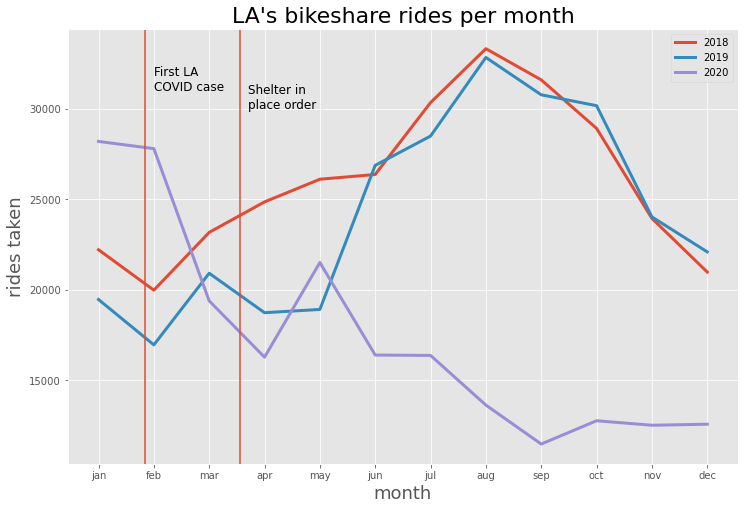

In [177]:
fig, ax = plt.subplots(figsize=(12,8))

x = [1,2,3,4,5,6,7,8,9,10,11,12]

ax.plot(x, la_df_2018, label='2018', linewidth=3)
ax.plot(x, la_df_2019, label='2019', linewidth=3)
ax.plot(x, la_df_2020, label='2020', linewidth=3)
ax.axvline(x= 1 + 26/31)
ax.text(2, 31000, 'First LA\nCOVID case', fontsize=12)
ax.axvline(x= 3 + 17/31)
ax.text(3.7, 30000, 'Shelter in\nplace order', fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("LA's bikeshare rides per month", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_volume.png');

link for desc: https://data.world/makeovermonday/2021w1

TIME PERMITTING: make a long graph of above

In [179]:
# Jan/Feb kind of reduce effect size of pandemic in 2020, but leaving '18 and '19 with two extra months inflates the difference between years
# Solution: remove from all years

la_df_2018_hr = la_df[(la_df['start_time'].dt.year == 2018) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2018_hr = la_df_2018_hr.groupby(la_df_2018_hr['start_time'].dt.hour).size()

la_df_2019_hr = la_df[(la_df['start_time'].dt.year == 2019) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2019_hr = la_df_2019_hr.groupby(la_df_2019_hr['start_time'].dt.hour).size()

la_df_2020_hr = la_df[(la_df['start_time'].dt.year == 2020) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2020_hr = la_df_2020_hr.groupby(la_df_2020_hr['start_time'].dt.hour).size()

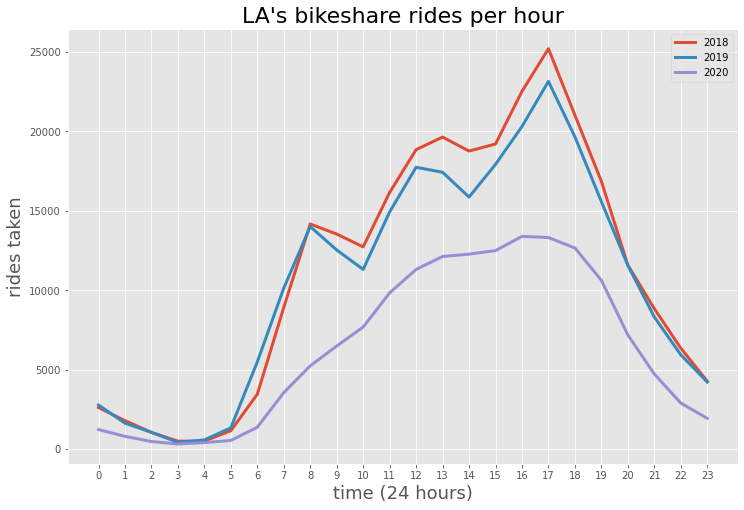

In [180]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12,8))

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

ax.plot(x, la_df_2018_hr, label='2018', linewidth=3)
ax.plot(x, la_df_2019_hr, label='2019', linewidth=3)
ax.plot(x, la_df_2020_hr, label='2020', linewidth=3)

ax.set_xticks(x)
#ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('time (24 hours)', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("LA's bikeshare rides per hour", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_hour.png');

Important note: in graph above Jan and Feb were excluded from all years to make a more balanced comparison

In [99]:
# New analysis: ridership over different weekdays

use_cols = ['start_time', 'plan_duration']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_wd = la_sdf.drop(*drop_cols)

#la_sdf_wd = (la_sdf_wd.withColumn('date', la_sdf_wd.start_time.cast(DateType()))
#             .withColumn('year', f.date_format('date', 'y'))
#             .withColumn('weekday', f.date_format('date', 'E'))
#             .drop('start_time')
#            .drop('date'))

la_sdf_wd.show()

+-------------------+-------------+
|         start_time|plan_duration|
+-------------------+-------------+
|2018-07-01 00:04:00|           30|
|2018-07-01 00:04:00|          365|
|2018-07-01 00:09:00|          365|
|2018-07-01 00:22:00|           30|
|2018-07-01 00:23:00|            1|
|2018-07-01 00:38:00|            1|
|2018-07-01 00:39:00|            1|
|2018-07-01 00:40:00|            1|
|2018-07-01 00:44:00|           30|
|2018-07-01 00:46:00|           30|
|2018-07-01 00:49:00|            1|
|2018-07-01 00:49:00|            1|
|2018-07-01 00:51:00|            1|
|2018-07-01 00:51:00|            1|
|2018-07-01 01:10:00|           30|
|2018-07-01 01:29:00|           30|
|2018-07-01 01:32:00|            1|
|2018-07-01 01:35:00|           30|
|2018-07-01 01:47:00|            1|
|2018-07-01 01:47:00|            1|
+-------------------+-------------+
only showing top 20 rows



In [100]:
# Fix up one column to tell us about membership

def dummy_code_users_la(col):
    # The plan_duration column tells how many days a bike pass lasts. If it's 1 day, it's just a walkup, not a member.
    # We're returning "is this row a member? 1: yes, 0: no."
    if col == '1':
        return 0
    else:
        return 1

udf = f.UserDefinedFunction(dummy_code_users_la, IntegerType())

la_sdf_wd = la_sdf_wd.withColumn('usertype', udf('plan_duration')).drop('plan_duration')

la_sdf_wd.show()

+-------------------+--------+
|         start_time|usertype|
+-------------------+--------+
|2018-07-01 00:04:00|       1|
|2018-07-01 00:04:00|       1|
|2018-07-01 00:09:00|       1|
|2018-07-01 00:22:00|       1|
|2018-07-01 00:23:00|       0|
|2018-07-01 00:38:00|       0|
|2018-07-01 00:39:00|       0|
|2018-07-01 00:40:00|       0|
|2018-07-01 00:44:00|       1|
|2018-07-01 00:46:00|       1|
|2018-07-01 00:49:00|       0|
|2018-07-01 00:49:00|       0|
|2018-07-01 00:51:00|       0|
|2018-07-01 00:51:00|       0|
|2018-07-01 01:10:00|       1|
|2018-07-01 01:29:00|       1|
|2018-07-01 01:32:00|       0|
|2018-07-01 01:35:00|       1|
|2018-07-01 01:47:00|       0|
|2018-07-01 01:47:00|       0|
+-------------------+--------+
only showing top 20 rows



In [101]:
la_df_wd = la_sdf_wd.toPandas()

la_df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812210 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   start_time  812210 non-null  object
 1   usertype    812210 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 9.3+ MB


In [102]:
# cast start_time to datetime type

la_df_wd['start_time'] = pd.to_datetime(la_df_wd['start_time'], infer_datetime_format=True)

la_df_wd.head()

,start_time,usertype
0,2018-07-01 00:04:00,1
1,2018-07-01 00:04:00,1
2,2018-07-01 00:09:00,1
3,2018-07-01 00:22:00,1
4,2018-07-01 00:23:00,0


In [117]:
la_df_wd18 = la_df_wd.copy()
la_df_wd19 = la_df_wd.copy()
la_df_wd20 = la_df_wd.copy()

la_df_wd18['usertype2'] = la_df_wd18['usertype']
la_df_wd19['usertype2'] = la_df_wd19['usertype']
la_df_wd20['usertype2'] = la_df_wd20['usertype']

In [118]:
# make a dataframe of relevant data for each year
# modifies dataframes directly, run cell above to reset

la_df_wd18 = (la_df_wd18[la_df_wd18['start_time'].dt.year == 2018]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd19 = (la_df_wd19[la_df_wd19['start_time'].dt.year == 2019]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd20 = (la_df_wd20[la_df_wd20['start_time'].dt.year == 2020]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd20

,date,ride_count,member_count
0,2020-01-01,572,357
1,2020-01-02,901,651
2,2020-01-03,972,748
3,2020-01-04,685,473
4,2020-01-05,632,484
...,...,...,...
361,2020-12-27,476,262
362,2020-12-28,103,90
363,2020-12-29,433,267
364,2020-12-30,407,206


### internal note

You now have a ride count per day for each year. Get the same for Chicago. Do your hypothesis test. (Don't need member_count for now, but maybe later)

# ====Chicago starts here====

In [2]:
# Two zip files also came out without the .csv in their file name, needed to be manually added

# Data comes in three distinct layouts: 2018 Q1 and 2019 Q2 look like other pre 2020 layouts w/ longer column names
# From 2020 on data includes bike type but drops gender and ride duration

# Make the first of three dataframes to be put together later
ch_sdf_set1 = spark.read.csv(['data/CH/Divvy_Trips_2018_Q1.csv', 'data/CH/Divvy_Trips_2019_Q2.csv'], header='true')

# Pick which columns we want (if you want more you have to do this for all three sets)
# For .py may want to leave all columns you can so you can def return a "complete" df for analysis
use_cols = ['01 - Rental Details Local End Time', '01 - Rental Details Local Start Time', 'User Type']
drop_cols = ch_sdf_set1.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop columns we don't want and rename what we're keeping
ch_sdf_set1 = (ch_sdf_set1.drop(*drop_cols)
               .withColumnRenamed('01 - Rental Details Local Start Time', 'start_time')
               .withColumnRenamed('01 - Rental Details Local End Time', 'end_time')
               .withColumnRenamed('user type', 'usertype'))

def dummy_code_users_ch(col):
    if col == 'Subscriber' or col == 'member':
        return 1
    else:
        return 0

udf = f.UserDefinedFunction(dummy_code_users_ch, IntegerType())

ch_sdf_set1 = ch_sdf_set1.withColumn('usertype', udf('usertype'))

ch_sdf_set1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [3]:
# Now for the rest of the pre-2020 data

# Gather all files
filelist = []
for quarter in [2,3,4]:
    filelist.append('data/CH/Divvy_Trips_2018_Q{}.csv'.format(quarter))
for quarter in [1,3,4]:
    filelist.append('data/CH/Divvy_Trips_2019_Q{}.csv'.format(quarter))

# Make the dataframe
ch_sdf_set2 = spark.read.csv(filelist, header='true')

# Pick which columns we want
use_cols = ['start_time', 'end_time', 'usertype']
drop_cols = ch_sdf_set2.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop the columns we don't want (no need to rename here)
ch_sdf_set2 = ch_sdf_set2.drop(*drop_cols)

# Using user defined function we made above
ch_sdf_set2 = ch_sdf_set2.withColumn('usertype', udf('usertype'))

ch_sdf_set2.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [4]:
# And finally the post-2020 data

# Gather all the files
filelist = ['data/CH/Divvy_Trips_2020_Q1.csv']
for month in range(4,13):
    filelist.append('data/CH/2020{0:0=2d}-divvy-tripdata.csv'.format(month))

# Make the dataframe
ch_sdf_set3 = spark.read.csv(filelist, header='true')

# Pick which columns we want
use_cols = ['started_at', 'ended_at', 'member_casual']
drop_cols = ch_sdf_set3.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop the columns we don't want and rename what we're keeping
ch_sdf_set3 = (ch_sdf_set3.drop(*drop_cols)
               .withColumnRenamed('started_at', 'start_time')
               .withColumnRenamed('ended_at', 'end_time')
               .withColumnRenamed('member_casual', 'usertype'))

ch_sdf_set3 = ch_sdf_set3.withColumn('usertype', udf('usertype'))

ch_sdf_set3.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [5]:
# Complete chicago DF ends up here before being sliced for whatever analysis

ch_sdf = ch_sdf_set1.union(ch_sdf_set2).union(ch_sdf_set3)

ch_sdf.show()

+-------------------+-------------------+--------+
|         start_time|           end_time|usertype|
+-------------------+-------------------+--------+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|
|2019-04-01 00:03:02|2019-04-01 00:20:30|       1|
|2019-04-01 00:11:07|2019-04-01 00:15:19|       1|
|2019-04-01 00:13:01|2019-04-01 00:18:58|       1|
|2019-04-01 00:19:26|2019-04-01 00:36:13|       1|
|2019-04-01 00:19:39|2019-04-01 00:23:56|       1|
|2019-04-01 00:26:33|2019-04-01 00:35:41|       1|
|2019-04-01 00:29:48|2019-04-01 00:36:11|       1|
|2019-04-01 00:32:07|2019-04-01 01:07:44|       0|
|2019-04-01 00:32:19|2019-04-01 01:07:39|       0|
|2019-04-01 00:36:20|2019-04-01 00:41:17|       1|
|2019-04-01 00:58:38|2019-04-01 01:04:43|       1|
|2019-04-01 01:09:41|2019-04-01 01:12:26|       1|
|2019-04-01 01:13:15|2019-04-01 01:20:38|       1|
|2019-04-01 01:18:09|2019-04-01 01:23:02|       1|
|2019-04-01 01:28:21|2019-04-01 01:31:45|       1|
|2019-04-01 01:31:35|2019-04-01

In [54]:
# Data too big to throw into pandas, and datetime types weren't doing us any favors
# so we'll grab necessary info through spark.

ch_sdf_months = (ch_sdf.withColumn('year', substring('start_time', 1,4).cast(IntegerType()))
          .withColumn('month', substring('start_time', 6,2).cast(IntegerType()))
          .withColumn('day', substring('start_time', 9,2).cast(IntegerType()))
          .withColumn('hour', substring('start_time', 12,2).cast(IntegerType())))

ch_sdf_months.show()

+-------------------+-------------------+----+-----+---+----+
|         start_time|           end_time|year|month|day|hour|
+-------------------+-------------------+----+-----+---+----+
|2019-04-01 00:02:22|2019-04-01 00:09:48|2019|    4|  1|   0|
|2019-04-01 00:03:02|2019-04-01 00:20:30|2019|    4|  1|   0|
|2019-04-01 00:11:07|2019-04-01 00:15:19|2019|    4|  1|   0|
|2019-04-01 00:13:01|2019-04-01 00:18:58|2019|    4|  1|   0|
|2019-04-01 00:19:26|2019-04-01 00:36:13|2019|    4|  1|   0|
|2019-04-01 00:19:39|2019-04-01 00:23:56|2019|    4|  1|   0|
|2019-04-01 00:26:33|2019-04-01 00:35:41|2019|    4|  1|   0|
|2019-04-01 00:29:48|2019-04-01 00:36:11|2019|    4|  1|   0|
|2019-04-01 00:32:07|2019-04-01 01:07:44|2019|    4|  1|   0|
|2019-04-01 00:32:19|2019-04-01 01:07:39|2019|    4|  1|   0|
|2019-04-01 00:36:20|2019-04-01 00:41:17|2019|    4|  1|   0|
|2019-04-01 00:58:38|2019-04-01 01:04:43|2019|    4|  1|   0|
|2019-04-01 01:09:41|2019-04-01 01:12:26|2019|    4|  1|   1|
|2019-04

In [17]:
ch_sdf_months = ch_sdf.groupBy('month').count().show()

+-----+-------+
|month|  count|
+-----+-------+
|   12| 415637|
|    1| 356862|
|    6|1276819|
|    3| 483518|
|    5| 968882|
|    9|1464289|
|    4| 550198|
|    8|1743300|
|    7|1653498|
|   10|1105379|
|   11| 605666|
|    2| 338721|
+-----+-------+



In [20]:
# get trip counts per month per year

ch_sdf_months18 = ch_sdf.filter(ch_sdf_months.year == 2018).groupBy('month').count().withColumnRenamed('count', '2018_ct')

ch_sdf_months19 = ch_sdf.filter(ch_sdf_months.year == 2019).groupBy('month').count().withColumnRenamed('count', '2019_ct')

ch_sdf_months20 = ch_sdf.filter(ch_sdf_months.year == 2020).groupBy('month').count().withColumnRenamed('count', '2020_ct')

In [23]:
# Takes a minute to run this cell, puts it all together. DAG in cell above

ch_sdf_months = ch_sdf_months18.join(ch_sdf_months19, ['month'])
ch_sdf_months = ch_sdf_months.join(ch_sdf_months20, ['month'])

ch_sdf_months.show()

+-----+-------+-------+-------+
|month|2018_ct|2019_ct|2020_ct|
+-----+-------+-------+-------+
|   12| 128972| 155092| 131573|
|    1| 109706| 103272| 143884|
|    6| 458419| 475395| 343005|
|    3| 174489| 165611| 143418|
|    5| 401150| 367458| 200274|
|    9| 438112| 493219| 532958|
|    4| 200112| 265310|  84776|
|    8| 530755| 590184| 622361|
|    7| 544703| 557315| 551480|
|   10| 344940| 371786| 388653|
|   11| 168774| 177176| 259716|
|    2| 102950|  96186| 139585|
+-----+-------+-------+-------+



In [24]:
# Moving to pandas for visualization. This dataframe is only counts, not the whole data, so it's not too big

ch_df_months = ch_sdf_months.toPandas()

ch_df_months.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   month    12 non-null     int32
 1   2018_ct  12 non-null     int64
 2   2019_ct  12 non-null     int64
 3   2020_ct  12 non-null     int64
dtypes: int32(1), int64(3)
memory usage: 464.0 bytes


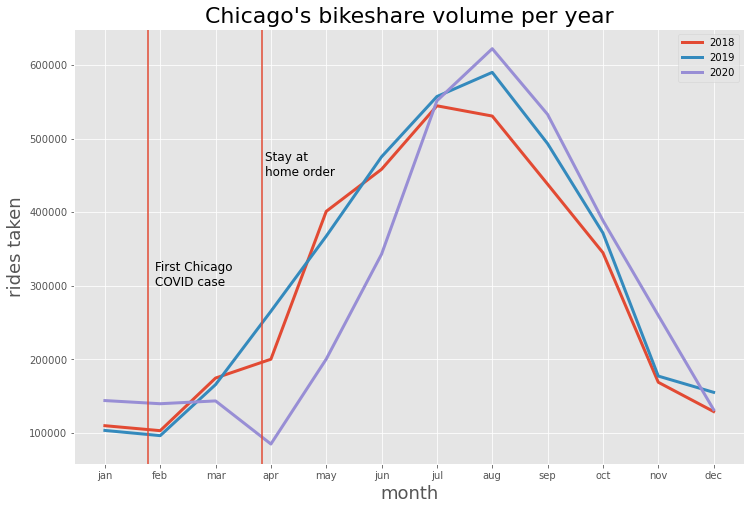

In [38]:
# plot

ch_df_months.sort_values(by=['month'], inplace=True)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(ch_df_months['month'], ch_df_months['2018_ct'], label='2018', linewidth=3)
ax.plot(ch_df_months['month'], ch_df_months['2019_ct'], label='2019', linewidth=3)
ax.plot(ch_df_months['month'], ch_df_months['2020_ct'], label='2020', linewidth=3)

ax.axvline(x= 1 + 24/31)
ax.text(1.9, 300000, 'First Chicago\nCOVID case', fontsize=12)
ax.axvline(x= 3 + 26/31)
ax.text(3.9, 450000, 'Stay at\nhome order', fontsize=12)
# Vertical line in July correlated w/ volume bouncing back. May not actually explain trend
#ax.axvline(x= 7 + 24/31)
#ax.text(8, 300000, 'Phase IV\nbusinesses reopen', fontsize=12)

ax.set_xticks(ch_df_months['month'])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("Chicago's bikeshare volume per year", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

So chicago did not see the same kind of hit as LA did (proportionally). By fall the program even continued its trend of growing each year. There are lots of potential explanations which could be investigated: Are Chicago's bike users are more established? Does LA has better established alternative forms of transportation? Did Chicago not enforce social distancing? Unfortunately these are beyond the scope of this analysis.

Potential hypothesis questions: Is the 2020 bikeshare volume drop different between LA and Chicago?

may want to graph total rides vs day of week but as a bar graph - subscribers or walk up; potential ideas: https://ashkansaboori.github.io/Files/2017-03-19-Insight%20into%20bike%20sharing%20in%20Bay%20Area.html

In [6]:
# New analysis: ridership over different weekdays

ch_sdf_wd = (ch_sdf.withColumn('date', ch_sdf.start_time.cast(DateType()))
             .withColumn('year', f.date_format('date', 'y'))
             .withColumn('weekday', f.date_format('date', 'E')))

ch_sdf_wd.show()

+-------------------+-------------------+--------+----------+----+-------+
|         start_time|           end_time|usertype|      date|year|weekday|
+-------------------+-------------------+--------+----------+----+-------+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:03:02|2019-04-01 00:20:30|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:11:07|2019-04-01 00:15:19|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:13:01|2019-04-01 00:18:58|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:19:26|2019-04-01 00:36:13|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:19:39|2019-04-01 00:23:56|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:26:33|2019-04-01 00:35:41|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:29:48|2019-04-01 00:36:11|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:32:07|2019-04-01 01:07:44|       0|2019-04-01|2019|    Mon|
|2019-04-01 00:32:19|2019-04-01 01:07:39|       0|2019-04-01|2019|    Mon|
|2019-04-01 00:36:20|2019

In [7]:
# get trip counts per weeday per year

ch_sdf_wd18 = ch_sdf_wd.filter(ch_sdf_wd.year == 2018).groupBy('weekday').count().withColumnRenamed('count', '2018_ct')
ch_sdf_wd18_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2018).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2018_member_ct')

ch_sdf_wd19 = ch_sdf_wd.filter(ch_sdf_wd.year == 2019).groupBy('weekday').count().withColumnRenamed('count', '2019_ct')
ch_sdf_wd19_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2019).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2019_member_ct')

ch_sdf_wd20 = ch_sdf_wd.filter(ch_sdf_wd.year == 2020).groupBy('weekday').count().withColumnRenamed('count', '2020_ct')
ch_sdf_wd20_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2020).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2020_member_ct')

In [8]:
# Takes a minute to run this cell, puts it all together. DAG in cell above

ch_sdf_wd = (ch_sdf_wd18.join(ch_sdf_wd18_m, ['weekday'])
             .join(ch_sdf_wd19, ['weekday'])
             .join(ch_sdf_wd19_m, ['weekday'])
             .join(ch_sdf_wd20, ['weekday'])
             .join(ch_sdf_wd20_m, ['weekday']))

ch_sdf_wd.show()

+-------+-------+--------------+-------+--------------+-------+--------------+
|weekday|2018_ct|2018_member_ct|2019_ct|2019_member_ct|2020_ct|2020_member_ct|
+-------+-------+--------------+-------+--------------+-------+--------------+
|    Sun| 405892|        260581| 426420|        256241| 527220|        271072|
|    Mon| 528569|        448097| 560269|        458780| 433696|        292044|
|    Thu| 562646|        491387| 588287|        486915| 491278|        328589|
|    Sat| 445385|        283964| 495219|        287163| 626179|        312376|
|    Wed| 576325|        504836| 584022|        494277| 482008|        329484|
|    Fri| 525681|        442978| 578107|        456966| 528235|        326048|
|    Tue| 558584|        494083| 585680|        497025| 453067|        315495|
+-------+-------+--------------+-------+--------------+-------+--------------+



In [9]:
# Moving to pandas for visualization. This dataframe is only counts, not the whole data, so it's not too big

ch_df_wd = ch_sdf_wd.toPandas()

ch_df_wd

,weekday,2018_ct,2018_member_ct,2019_ct,2019_member_ct,2020_ct,2020_member_ct
0,Sun,405892,260581,426420,256241,527220,271072
1,Mon,528569,448097,560269,458780,433696,292044
2,Thu,562646,491387,588287,486915,491278,328589
3,Sat,445385,283964,495219,287163,626179,312376
4,Wed,576325,504836,584022,494277,482008,329484
5,Fri,525681,442978,578107,456966,528235,326048
6,Tue,558584,494083,585680,497025,453067,315495


In [10]:
# Unfortunately need to sort by weekday
# Don't run this cell multiple times, 'weekday' will all become NaN

wd_sort = dict(zip(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], range(7)))

ch_df_wd['weekday'] = ch_df_wd['weekday'].map(wd_sort)

ch_df_wd.sort_values(by=['weekday'], inplace=True)

ch_df_wd

,weekday,2018_ct,2018_member_ct,2019_ct,2019_member_ct,2020_ct,2020_member_ct
1,0,528569,448097,560269,458780,433696,292044
6,1,558584,494083,585680,497025,453067,315495
4,2,576325,504836,584022,494277,482008,329484
2,3,562646,491387,588287,486915,491278,328589
5,4,525681,442978,578107,456966,528235,326048
3,5,445385,283964,495219,287163,626179,312376
0,6,405892,260581,426420,256241,527220,271072


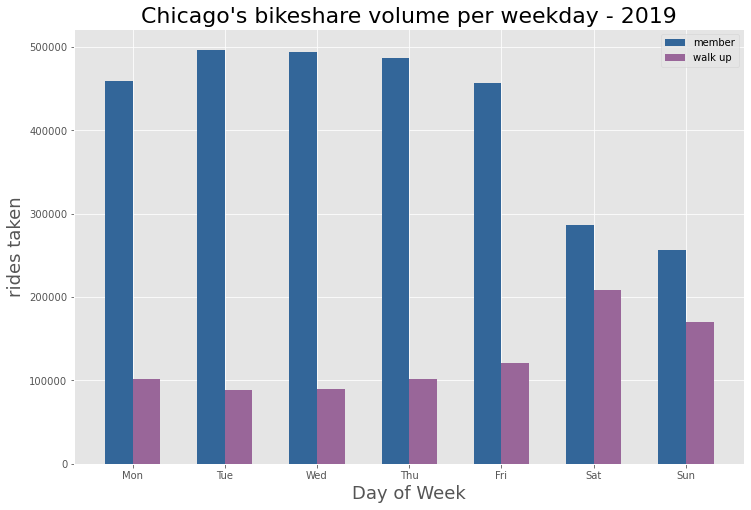

In [11]:
# visualization of rides across weekdays for members and non-members

fig, ax = plt.subplots(figsize=(12,8))

width = 0.3
ax.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2019_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2019_ct']-ch_df_wd['2019_member_ct'], width=width, align='center', label='walk up', color=(0.6, 0.4, 0.6, 1))

ax.set_xticks(ch_df_wd['weekday'])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax.set_xlabel('Day of Week', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("Chicago's bikeshare volume per weekday - 2019", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

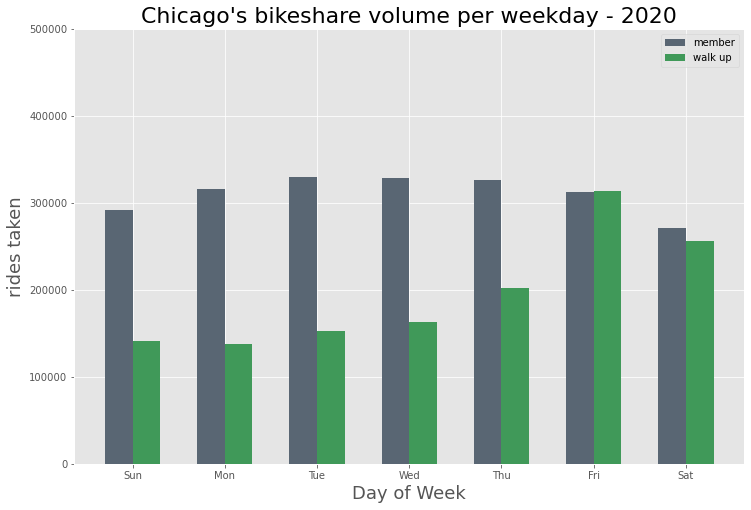

In [12]:
# comparison to 2020

fig, ax = plt.subplots(figsize=(12,8))

width = 0.3
ax.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2020_member_ct'], width=width, align='center', label='member', color=(0.35, 0.4, 0.45, 1))
ax.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2020_ct']-ch_df_wd['2020_member_ct'], width=width, align='center', label='walk up', color=(0.25, 0.6, 0.35, 1))
ax.set_ylim(0, 500000)

ax.set_xticks(ch_df_wd['weekday'])
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax.set_xlabel('Day of Week', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("Chicago's bikeshare volume per weekday - 2020", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

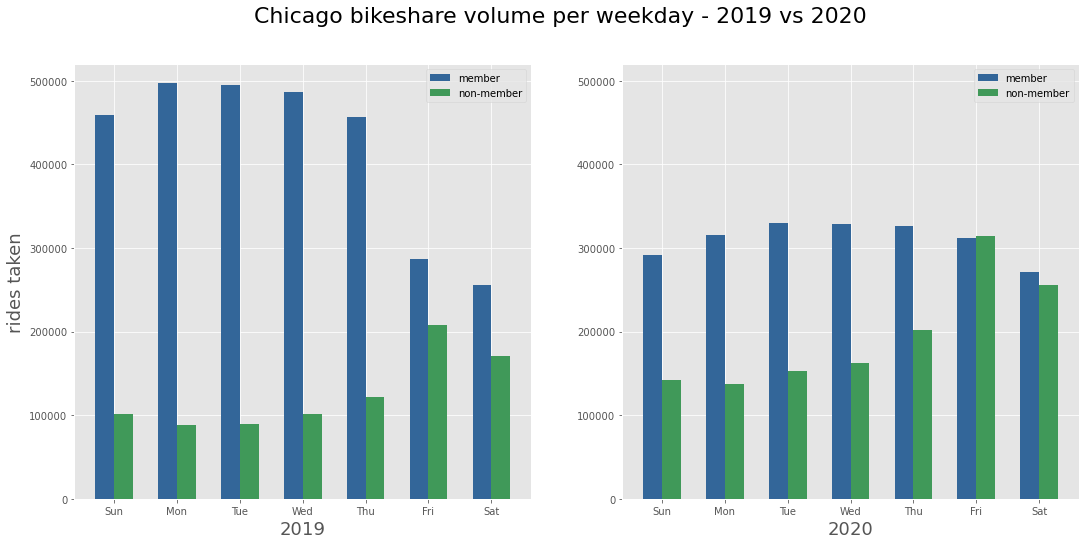

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))

width = 0.3
ax1.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2019_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax1.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2019_ct']-ch_df_wd['2019_member_ct'], width=width, align='center', label='non-member', color=(0.25, 0.6, 0.35, 1))
ax1.set_ylim(0, 520000)

ax1.set_xticks(ch_df_wd['weekday'])
ax1.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax1.set_xlabel('2019', fontsize=18)
ax1.set_ylabel('rides taken', fontsize=18)

ax1.legend()

ax2.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2020_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax2.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2020_ct']-ch_df_wd['2020_member_ct'], width=width, align='center', label='non-member', color=(0.25, 0.6, 0.35, 1))
ax2.set_ylim(0, 520000)

ax2.set_xticks(ch_df_wd['weekday'])
ax2.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax2.set_xlabel('2020', fontsize=18)

ax2.legend()

fig.suptitle('Chicago bikeshare volume per weekday - 2019 vs 2020', fontsize=22);

#plt.savefig('graphs/chicago_weekday.png');

In [136]:
# getting a pandas df of chicago daily ride counts

ch_sdf_dy = (ch_sdf.withColumn('date', ch_sdf.start_time.cast(DateType()))
             #.withColumn('year', f.date_format('date', 'y'))
             .drop(*['start_time', 'end_time', 'usertype'])
             .groupBy('date').count()
             .withColumnRenamed('count', 'ride_ct'))

ch_sdf_dy.show()

+----------+-------+
|      date|ride_ct|
+----------+-------+
|2019-05-08|  10803|
|2019-06-04|  15878|
|2018-05-28|  17309|
|2018-08-10|  19250|
|2020-08-24|  16372|
|2018-03-17|   3937|
|2018-06-06|  17181|
|2019-11-01|   7312|
|2019-11-18|   7795|
|2019-09-22|   6901|
|2020-08-05|  17856|
|2020-07-24|  20673|
|2020-01-21|   5187|
|2020-11-29|   5453|
|2018-08-08|  19929|
|2018-08-11|  20204|
|2019-11-21|   6717|
|2018-10-05|   9710|
|2018-11-02|  10174|
|2018-09-01|   8649|
+----------+-------+
only showing top 20 rows



In [135]:
ch_sdf_dy18 = ch_sdf_dy.groupBy('date').count().withColumnRenamed('count', 'ride_ct')

ch_sdf_dy18.show()

+----------+-------+
|      date|ride_ct|
+----------+-------+
|2019-05-08|  10803|
|2019-06-04|  15878|
|2018-05-28|  17309|
|2018-08-10|  19250|
|2020-08-24|  16372|
|2018-03-17|   3937|
|2018-06-06|  17181|
|2019-11-01|   7312|
|2019-11-18|   7795|
|2019-09-22|   6901|
|2020-08-05|  17856|
|2020-07-24|  20673|
|2020-01-21|   5187|
|2020-11-29|   5453|
|2018-08-08|  19929|
|2018-08-11|  20204|
|2019-11-21|   6717|
|2018-10-05|   9710|
|2018-11-02|  10174|
|2018-09-01|   8649|
+----------+-------+
only showing top 20 rows



In [132]:
ch_sdf_dy18.describe().show()

+-------+-----------------+
|summary|          2018_ct|
+-------+-----------------+
|  count|              365|
|   mean|9871.457534246576|
| stddev|5908.680845737957|
|    min|              376|
|    max|            20663|
+-------+-----------------+



# ==== Hypothesis testing starts here ====

Find the difference between 18-19, the first difference score, and compare it to the difference between 19-20, the second difference score. Are these differences statistically different?

Difference in what? Total rides over the year (single number)? Average rides per day (365, mean + standev)? Week (n ~ 52)? Daily is probably the way to go.

Could compare differences in quarters instead of annual means instead (especially chicago), but quarters go up and down significantly whereas the year as a whole evens out.

In [65]:
# pull ch_sdf and la_sdf from above

In [66]:
# make into smaller df of daily ride counts, 

In [67]:
# can port to pandas, remove leap day

In [ ]:
# port to numpy? do t-test